# Notebook 2 of 4 - Exploratory Data Analysis
**Code and Markdown Author:** _Boom Devahastin Na Ayudhya_ and _Muaaz Ahmed Noor_

This notebook seeks to explore the data first at a high level, followed by deep dives accordingly based on standout patterns or peculiarities revealed by the data. The intention is to provide a firm basis for the intuition behind Feature Engineering, which comes immediately afterwards.

In [ ]:
# Load Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import datetime as dt

## Section 0: Spark Set Up

First, perform the general setup to create the Spark cluster hosted on AWS.

In [ ]:
%%capture
!apt update
!apt install gcc python-dev libkrb5-dev
!pip install sparkmagic

In [ ]:
%%capture
%load_ext sparkmagic.magics 

In [ ]:
# Create Spark Sessions: Enter your Master Public DNS with the proper formatting and host, and update the password
Password1 = 'Fin@lproject'
%spark add -s spark_session -l python -u http://ec2-34-227-228-83.compute-1.amazonaws.com/ -a cis545-livy -p lyoko -t Basic_Access

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1639365520284_0002,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


**NOTE:** If you ever need to restart, you may need to 
```
%spark delete -s spark_session
```

...or just factory reset runtime under the runtime tab.

Read massive datafile from S3 into Spark

In [ ]:
%%spark
from pyspark.sql.types import *

# Read and Create SDF
raw_data_sdf = spark.read.options(header=True, inferSchema=True).csv('s3://cis545projectbmt/wrangle_data/part-00000-c84f734f-86af-42be-9edc-dc2e6ea5f2d7-c000.csv')
raw_data_sdf.createOrReplaceTempView("raw_data")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Prevent limit caps
pd.set_option('display.max_columns', None)

## Section 1: Generic EDA

This subsection consists of high-level generic exploratory items such as checking that the loaded dataframe looks the way it should, the dimensions of the data, etc.

The key takeaways from this subsection are that:
- The dataset consists of 13,594,712 rows and 54 columns
- This is not purely a cross-sectional or a time-series dataset, but rather panel data since each row/observation represents the month-end snapshot for a particular customer.
- There are 942,993 unique `cust_code` (customer IDs)

#### (a) High-Level View

Upon inspecting the dataframe, we see we have feature columns spanning demographics, banking-specific tags, and banking products. The data is indexed by customer ID at a particular point in time making this panel data.

In [ ]:
# Peak into dataframe

%%spark
raw_data_sdf.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+---------+----------+-----------------+---+---+-------------------+--------+----------------+-------+--------------------+---------+--------+----------------------+------------------+----------+---------------+--------+----+-----------+--------+------+------+----------+------------+----------+------------+-------------+------------+-----------+-------------------+---------------+--------------------+-------------------+--------------------+------------------+---------+-----+--------+--------+-----+-----+-----------+----------+------------+-------+----------+------------+-----+----------+---------------+------------------+---------------------+------------------------+
|year_month|cust_code|emp_status|residence_country|sex|age|first_contract_date|new_cust|months_as_senior|primary|last_date_as_primary|cust_type|rel_type|same_residence_country|diff_birth_country|emp_spouse|joining_channel|deceased|addr|province_cd|province|active|income|   segment|savings_acct|guarantees|curre

#### (b) Dimensions of Dataset

We'll need to get an idea of how large this data actually is and how many features we'll have to sift through.

In [ ]:
# Check Dimensions

%%spark
print(f'The data has {raw_data_sdf.count()} rows and {len(raw_data_sdf.columns)} columns')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The data has 13594712 rows and 54 columns

Let's check how many unique customers there are

In [ ]:
# Check unique customer ID's

%%spark

raw_data_sdf.createOrReplaceTempView("raw_data")

query = '''SELECT COUNT(DISTINCT cust_code) AS Num_Unique_Customer_Codes
           FROM raw_data
           '''

# Save the output sdf of spark.sql() as answer_sdf and convert to Pandas
spark.sql(query).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------------+
|Num_Unique_Customer_Codes|
+-------------------------+
|                   943993|
+-------------------------+

We notice that the data has 13,594,712 rows and 54 columns but only 943,993 customers.

**_Taking Random Subset of the Panel Data_**

As a result, most of the subsequent EDA here will need to be handled with Spark due to its size, but any aggregated metrics can be handled with Pandas and corresponding visualization packages. If data is too large to plot (e.g. in frequency distribution histograms), we will take a subset of the data (about 944,000 rows) and generate plots for that as recommended by Varun in [Piazza Post @2505](https://piazza.com/class/ks4pi71f1ys25w?cid=2505).

Note that Pandas can only handle around ~1,000,000 rows so we'll taking approximately a random 10% of the customer codes and their complete time series for the purpose of visualization.

Note that the data is already shuffled so we can just take the 10% of this by directly writing a query.

In [ ]:
%%spark

# The 94400 in the LIMIT clause  is approx 10% of the number of customers
query = '''SELECT *
           FROM raw_data
           WHERE cust_code IN (SELECT DISTINCT cust_code
                               FROM raw_data
                               LIMIT 94400)
           ORDER BY cust_code, year_month;
    ''' 

eda_subset_df = spark.sql(query)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Take spark df and put into Colab environment
%spark -o eda_subset_df

# Check this looks okay
eda_subset_df.head(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

,year_month,cust_code,emp_status,residence_country,sex,age,first_contract_date,new_cust,months_as_senior,primary,cust_type,rel_type,same_residence_country,diff_birth_country,emp_spouse,joining_channel,deceased,addr,province_cd,province,active,income,segment,savings_acct,guarantees,current_acct,derivada_acct,payroll_acct,junior_acct,max_particular_acct,particular_acct,particular_plus_acct,short_term_deposits,medium_term_deposits,long_term_deposits,e_account,funds,mortgage,pensions,loans,taxes,credit_card,securities,home_account,payroll,pensions_2,direct_debit,cc,ym,imputed_payroll,imputed_pensions_2,first_imputed_payroll,first_imputed_pensions_2
0,2015-01-28,15902,B,ES,H,57,1995-01-16,0,246,1,1,A,S,N,N,KAT,N,1,28,MADRID,1,230408.0,top,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,15902,2015-01-28,0,0,0,0
1,2015-02-28,15902,B,ES,H,57,1995-01-16,0,246,1,1,A,S,N,N,KAT,N,1,28,MADRID,1,230408.0,top,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,15902,2015-02-28,0,0,0,0
2,2015-03-28,15902,B,ES,H,57,1995-01-16,0,246,1,1,A,S,N,N,KAT,N,1,28,MADRID,1,230408.0,top,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,15902,2015-03-28,0,0,0,0
3,2015-04-28,15902,B,ES,H,57,1995-01-16,0,246,1,1,A,S,N,N,KAT,N,1,28,MADRID,1,230408.0,top,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,15902,2015-04-28,0,0,0,0
4,2015-05-28,15902,B,ES,H,57,1995-01-16,0,246,1,1,A,S,N,N,KAT,N,1,28,MADRID,1,230408.0,top,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,15902,2015-05-28,0,0,0,0
5,2015-06-28,15902,B,ES,H,57,1995-01-16,0,246,1,1,A,S,N,N,KAT,N,1,28,MADRID,1,230408.0,top,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,15902,2015-06-28,0,0,0,0
6,2015-07-28,15902,B,ES,H,57,1995-01-16,0,246,1,1,A,S,N,N,KAT,N,1,28,MADRID,1,230408.0,top,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,15902,2015-07-28,0,0,0,0
7,2015-08-28,15902,B,ES,H,57,1995-01-16,0,247,1,1,A,S,N,N,KAT,N,1,28,MADRID,1,230408.0,top,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,15902,2015-08-28,0,0,0,0
8,2015-09-28,15902,B,ES,H,58,1995-01-16,0,248,1,1,A,S,N,N,KAT,N,1,28,MADRID,1,230408.0,top,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15902,2015-09-28,0,0,0,0
9,2015-10-28,15902,B,ES,H,58,1995-01-16,0,249,1,1,A,S,N,N,KAT,N,1,28,MADRID,1,230408.0,top,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15902,2015-10-28,0,0,0,0


#### (c) Correlation Heat Map

We suspect there may be highly correlated features in the dataset. Constructing a correlation heatmap will help us visualize this more easily. If we need to do any kNN imputations for any particular column, this will also give us some insight into which features to consider using to help us achieve that.

Although creating a correlation heatmap using pandas and seaborn is easy, we are not able to do so as our dataset is too large for Pandas to handle so we initially had to work in Spark.

However, since seaborn and matplotlib do not work in Spark environments, We attempted to work around this by just visualizing a subset of the data as discussed above.

In [ ]:
# Get correlation matrix for numeric columns only
heatmap_columns = ['age', 'months_as_senior', 'active', 'income', 
                   'current_acct', 'payroll_acct', 'particular_acct', 
                   'particular_plus_acct', 'long_term_deposits', 'e_account', 
                   'funds', 'mortgage', 'pensions', 'loans', 'taxes',
                   'credit_card', 'securities', 'home_account', 'payroll',
                   'pensions_2', 'direct_debit']

corr_df = eda_subset_df[heatmap_columns].corr()

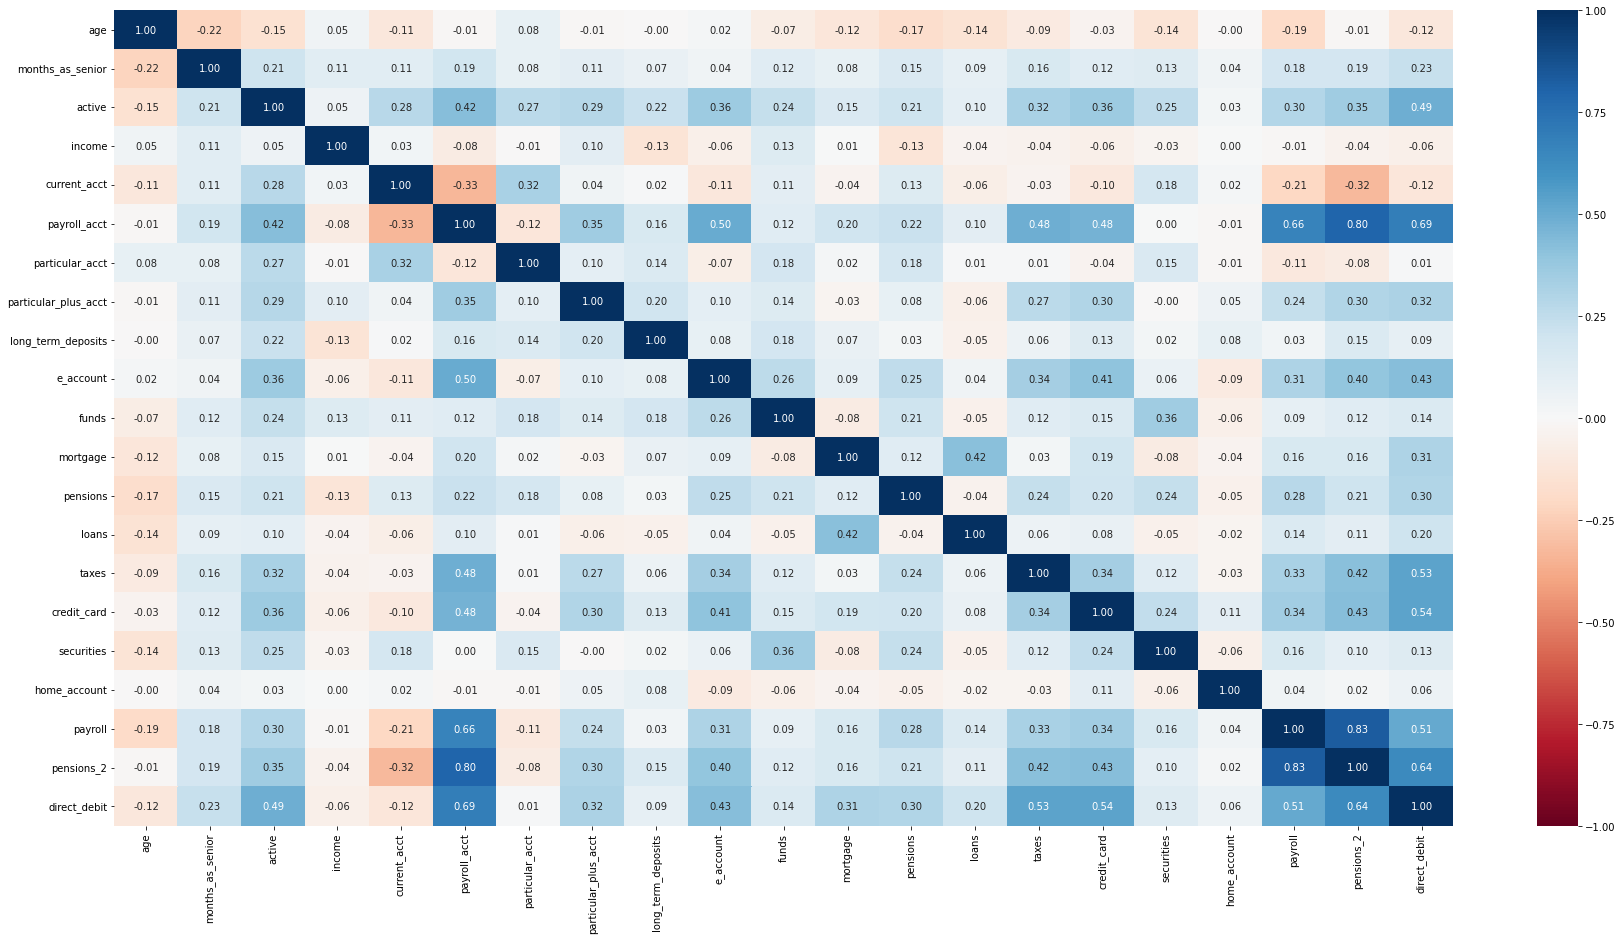

In [ ]:
# Correlation matrix: to identify multicollinearity between features, and whether any features strongly corr with target

# Plot heatmap
plt.figure(figsize = (30,15))
sns.heatmap(corr_df,
            cmap = 'RdBu',                                                      # Change color scheme to make it more intuitive (+ = Blue, - = Red)
            annot = True,
            vmin = -1,
            vmax = +1,
            fmt = '.2f');

**_Warning:_** Since  this is a small subset of the data, it is difficult to generalize these correlations to the whole dataset.

Nevertheless, from this we see that features are mostly uncorrelated for th most part, except `direct_debit` appears to be highly correlated with a number of accounts. This is in line with expectations however, since direct_debit (aka Checking Accounts) are the primary accounts held by virtually every banking customer as it reflects every day need. This is closely followed by `payroll` and `pensions_2`, which also make sense since users who are likely employed will need to set those up for income and retirement.

_(**Note:** The data dictionary does not explain the difference between the two payroll or pension accounts, even though clearly these are not copies of each other since the correlation is not 1)_

### (d) Creating Feature Groups

To better structure the EDA Deep Dives and Feature Engineering, it makes sense to partition the set of features into meaningful groups. Based on the data, there are three main groups
- Personal Demographic Features
- Banking Tag Features
- Product Dummy Features

In [ ]:
### Create feature grouping aliases to simplify analysis

# Personal Demographics (Note: `province_cd` is the unique code for a given `province`)
demographic_features = ["age", "emp_status", "residence_country", "sex", "deceased",
                        "addr", "province_cd", "province", "income", "segment"]                     

# Banking Tags
banking_tag_features = ["first_contract_date", "new_cust", "months_as_senior",
                        "primary", "last_date_as_primary", "cust_type",
                        "rel_type", "same_residence_country", "diff_birth_country",
                        "emp_spouse", "joining_channel", "active"]

# The 24 products
product_dummies = ['savings_acct', 'guarantees', 'current_acct', 
                   'derivada_acct', 'payroll_acct', 'junior_acct', 
                   'max_particular_acct', 'particular_acct', 'particular_plus_acct',
                   'short_term_deposits', 'medium_term_deposits', 'long_term_deposits',
                   'e_account', 'funds', 'mortgage',
                   'pensions', 'loans', 'taxes', 
                   'credit_card', 'securities', 'home_account', 
                   'payroll', 'pensions_2', 'direct_debit']

## Section 2: Demographics Analysis

This sub-section does a deep dive into the Demographics features grouped above.

#### (a) Income Analysis

Since distplots/histograms would require unprocessed raw data as input, we had to take a subset of data to be able to plot this in seaborn/matplotlib as this was not possible within the Spark environment.

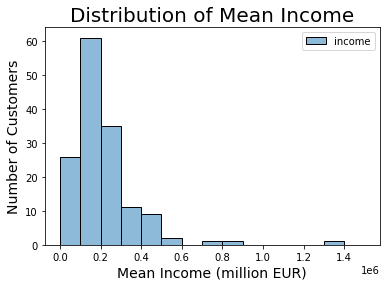

In [ ]:
##### Pandas Version of Plotting (since Spark DF too huge to export)

# Get average income for each customer in subset
income_summaries = eda_subset_df[['cust_code', 'income']].groupby(by = 'cust_code', axis = 0).mean()

# Plot Distribution of Income
sns.histplot(income_summaries,
             binwidth = 0.1*10**6,
             binrange = (0,1.5*10**6),
             color = 'green');
plt.rcParams["patch.force_edgecolor"] = True;
plt.ticklabel_format(axis="x", style="sci", scilimits=(6,6))
plt.xlabel("Mean Income (million EUR)", fontsize = 14);
plt.ylabel('Number of Customers', fontsize = 14);
plt.title('Distribution of Mean Income', fontsize = 20);

**Observations:** Income is heavily right skewed with a clear outlier in the far right end with a few ultra high net work individuals. Again, note this is a small subset though so may not be representative of the whole dataset!

#### (b) Age Analysis

Similar to the case of income, since distplots/histograms would require unprocessed raw data as input, we had to take a subset of data to be able to plot this in seaborn/matplotlib as this was not possible within the Spark environment.

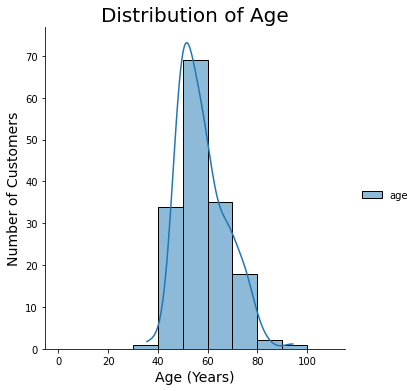

In [ ]:
##### Pandas Version of Plotting (since Spark DF too huge to export)

### Examine average age of subset (this is 1.5 years so age won't change much)
age_summaries = eda_subset_df[['cust_code', 'age']].groupby(by = 'cust_code', axis = 0).mean()

### Distribution of Age
sns.displot(age_summaries, 
             kde = True,
             binwidth = 10,
             binrange = (0,101),
             color = 'green');
plt.rcParams["patch.force_edgecolor"] = True;
plt.xlabel("Age (Years)", fontsize = 14);
plt.ylabel('Number of Customers', fontsize = 14);
plt.title('Distribution of Age', fontsize = 20);

**Observations:** Almost a normal distribution, but note this is a subset. The average age of customers appears to be in the early 50's. This reinforces our earlier observation that a lot of these people should have active payroll and pension accounts, but given their age they may be risk-averse to invest in securities.

#### (c) Employment Status

This is taken on the entire (time, cust_code) dataset since customer employment status may have changed many times over their tenure.

As a reminder, the data dictionary tells us:
- A: active
- B: ex employed
- F: filial
- N: not employee
- S: passive

In [ ]:
%%spark

query = ''' SELECT emp_status, COUNT(*) AS frequency
            FROM raw_data
            GROUP BY emp_status
            ORDER BY frequency DESC
            '''

emp_status_dist_df = spark.sql(query)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Make available in Colab as Pandas DF
%spark -o emp_status_dist_df

# View
emp_status_dist_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

,emp_status,frequency
0,N,13586115
1,B,3565
2,F,2523
3,A,2492
4,S,17


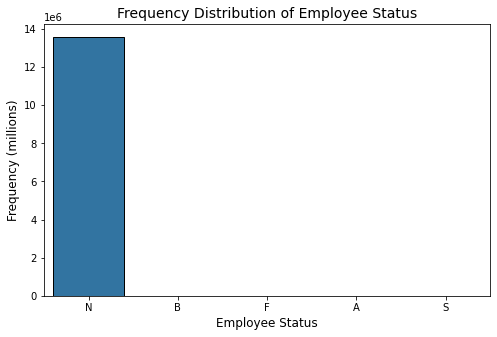

In [ ]:
# Plot
plt.figure(figsize = (8,5))
sns.barplot(x = 'emp_status', y = 'frequency', data = emp_status_dist_df);
plt.xlabel("Employee Status", fontsize = 12);
plt.ticklabel_format(axis="y", style="sci", scilimits=(6,6));
plt.ylabel('Frequency (millions)', fontsize = 12);
plt.title('Frequency Distribution of Employee Status', fontsize = 14);

**Observations:** This is a vast class imbalance; most customers in the dataset are not employees of the bank (class 'N'). This is of course expected.

#### (d) Residence Country

This is just "Spain" but need to show to confirm.

In [ ]:
%%spark

query = ''' SELECT residence_country, COUNT(DISTINCT cust_code) as num_customers
            FROM raw_data
            GROUP BY residence_country
            ORDER BY num_customers DESC
            '''

spark.sql(query).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+-------------+
|residence_country|num_customers|
+-----------------+-------------+
|               ES|       940042|
|               FR|          319|
|               AR|          290|
|               GB|          289|
|               DE|          288|
|               US|          232|
|               CO|          211|
|               IT|          182|
|               RO|          175|
|               MX|          160|
|               BR|          143|
|               VE|          142|
|               CH|          130|
|               EC|          129|
|               BE|           96|
|               BO|           93|
|               PT|           90|
|               PY|           86|
|               CL|           61|
|               PE|           55|
+-----------------+-------------+
only showing top 20 rows

**Observations:** Most customers (>99%) in the dataset reside in Spain. It doesn't look like this is a major distribution.

We won't bother plotting this because there are too many countries and we know Spain will just tower above the rest.

#### (e) Address

This tag should just represent whether someone has an address in the database. Everyone should have one.

In [ ]:
%%spark

query = ''' SELECT addr, COUNT(*) as frequency
            FROM raw_data
            GROUP BY addr
            '''

spark.sql(query).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+---------+
|addr|frequency|
+----+---------+
|null|        1|
|   1| 13594711|
+----+---------+

**Observations:** Everybody has an address, except for one person. We could probably keep them in and not use this feature instead of dropping the observation entirely.

#### (f) Sex Distribution

Here V represents Male and H represents Female in Santander's Spanish abbreviations.

In [ ]:
# SparkSQL query for distribution
%%spark

query = ''' SELECT sex, COUNT(DISTINCT cust_code) as num_customers
            FROM raw_data
            GROUP BY sex
            ORDER BY num_customers DESC
            '''

sex_df = spark.sql(query)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Take it to Colab
%spark -o sex_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

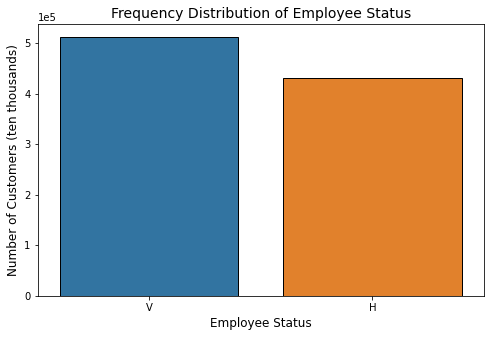

In [ ]:
# Plot
plt.figure(figsize = (8,5))
sns.barplot(x = 'sex', y = 'num_customers', data = sex_df);
plt.xlabel("Employee Status", fontsize = 12);
plt.ticklabel_format(axis="y", style="sci", scilimits=(5,5));
plt.ylabel('Number of Customers (ten thousands)', fontsize = 12);
plt.title('Frequency Distribution of Employee Status', fontsize = 14);

**Observations:** There appear to be sligtly fewer females than male in the dataset, but no wild class imbalance.

#### (g) Deceased Counts

The 'N' (no) class represents customers who are alive, and the 'S' (si) class represents customers who are dead.

In [ ]:
%%spark

query = ''' SELECT Deceased, COUNT(*) as num_customers
            FROM raw_data
            GROUP BY Deceased
            ORDER BY num_customers DESC
            '''

spark.sql(query).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+-------------+
|Deceased|num_customers|
+--------+-------------+
|       N|     13560534|
|       S|        34178|
+--------+-------------+

**Observations:** No need to plot this since the difference between the orders of magnitude are astronomical. Since it does not make sense to make forward-looking predictions on someone who is already dead, we can remove customers (with their entire time series) who have been marked at `Deceased == S` at any point in their time series.

#### (h) Segment

The data dictionary outlines these segments as VIP/Top, Individuals, or College Graduated. There was no further explanation, so we are assuming that "College Graduated" simply means advanced degree holders (e.g. PhDs and academics). Recall that any nulls were placed into a new group called "other" in the Data Cleaning notebook. 

In [ ]:
%%spark

query = ''' SELECT segment, COUNT(*) AS frequency
            FROM raw_data
            GROUP BY segment
            ORDER BY segment
            '''

segment_dist_df = spark.sql(query)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Make available in Colab as Pandas DF
%spark -o segment_dist_df

# View
segment_dist_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

,segment,frequency
0,graduate_academic,4929577
1,individual,7947485
2,other,156407
3,top,561243


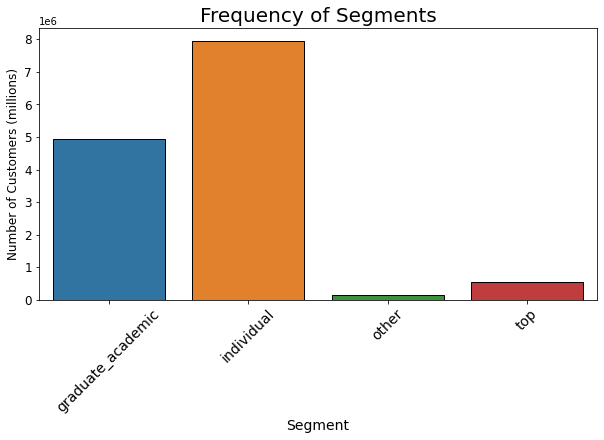

In [ ]:
# Plot
plt.figure(figsize = (10,5))
sns.barplot(x = 'segment', y = 'frequency', data = segment_dist_df);
plt.xticks(rotation = 45);
plt.xlabel('Segment', fontsize = 14);
plt.xticks(fontsize = 14)
plt.ylabel('Number of Customers (millions)', fontsize = 12);
plt.yticks(fontsize = 12)
plt.title('Frequency of Segments', fontsize = 20);

**Observations:** Most customers are generic individuals. The next class of individuals are advanced graduate degree holders, and only a handful designated VIPs are expected.

This does beg some extension questions though:
- What is the average age for each bracket?
- What is the average income for each bracket?

Let us investigate these extension questions.

First, to answer "What is the average age for each bracket?"

In [ ]:
%%spark

query = ''' SELECT segment, AVG(age) AS average_age, AVG(income) AS average_income
            FROM (SELECT DISTINCT cust_code, segment, age, income
                  FROM raw_data) as subquery
            GROUP BY segment
            ORDER BY segment
            '''

segment_deep_dive_df = spark.sql(query)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Make available in Colab as Pandas DF
%spark -o segment_deep_dive_df

# View
segment_deep_dive_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

,segment,average_age,average_income
0,graduate_academic,24.148117,117436.901303
1,individual,48.791350,141046.373423
2,other,30.488390,118277.227308
3,top,54.914086,173394.775999


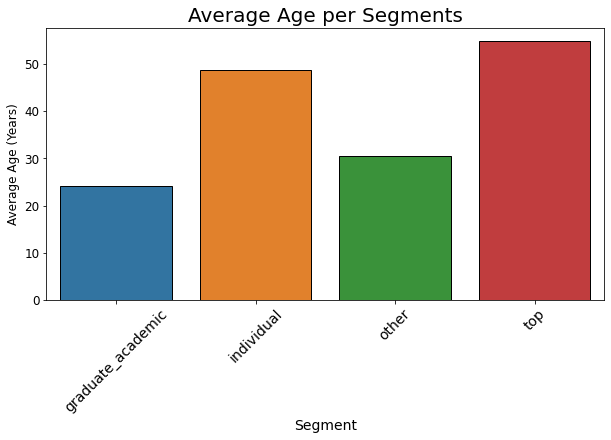

In [ ]:
# Plot average age per segment
plt.figure(figsize = (10,5))
sns.barplot(x = 'segment', y = 'average_age', data = segment_deep_dive_df);
plt.xticks(rotation = 45);
plt.xlabel('Segment', fontsize = 14);
plt.xticks(fontsize = 14)
plt.ylabel('Average Age (Years)', fontsize = 12);
plt.yticks(fontsize = 12)
plt.title('Average Age per Segments', fontsize = 20);

**Observations:** 
- Both the `individual` matches the mean age of the dataset, which is expected since it is the most populous.
- It is interesting to see that most of the `graduate_academic` advanced degree holders are really fresh graduates though since the average age appears to be around 24
- Unsurprisingly, the `top` (VIP) customers are stereotypical wealthy old people. 

Next, to answer "What is the average income for each bracket?"

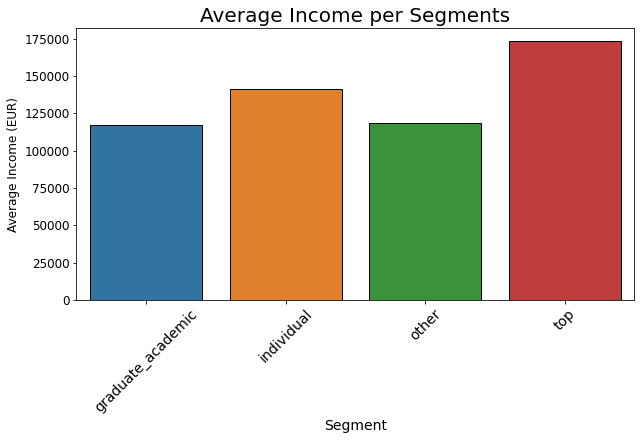

In [ ]:
# Plot average income per segment
plt.figure(figsize = (10,5))
sns.barplot(x = 'segment', y = 'average_income', data = segment_deep_dive_df);
plt.xticks(rotation = 45);
plt.xlabel('Segment', fontsize = 14);
plt.xticks(fontsize = 14)
plt.ylabel('Average Income (EUR)', fontsize = 12);
plt.yticks(fontsize = 12)
plt.title('Average Income per Segments', fontsize = 20);

**Observations:**
- This is very in line with expectations.
- The `top` obviously make the most money, which is why the bank considers them VIPs.
- Young `graduate_academic` advanced degree holders are not making as much as the (`individual`) majority of the customers (most of whom are twice their age and have years of work experience). 

#### (i) Provincial Origin

There is a 1:1 mapping between province and province_cd so we are only visualizing province.

In [ ]:
%%spark

query = ''' SELECT province, COUNT(DISTINCT cust_code) as num_customers
            FROM raw_data
            GROUP BY province
            ORDER BY num_customers DESC
            '''

province_dist_df = spark.sql(query)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Make available in Colab as Pandas DF
%spark -o province_dist_df

# View Top 10
province_dist_df.head(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

,province,num_customers
0,MADRID,303911
1,BARCELONA,90141
2,VALENCIA,48847
3,SEVILLA,41271
4,"CORUÑA, A",29262
5,MURCIA,28137
6,MALAGA,25028
7,ZARAGOZA,23514
8,ALICANTE,22674
9,CADIZ,20193


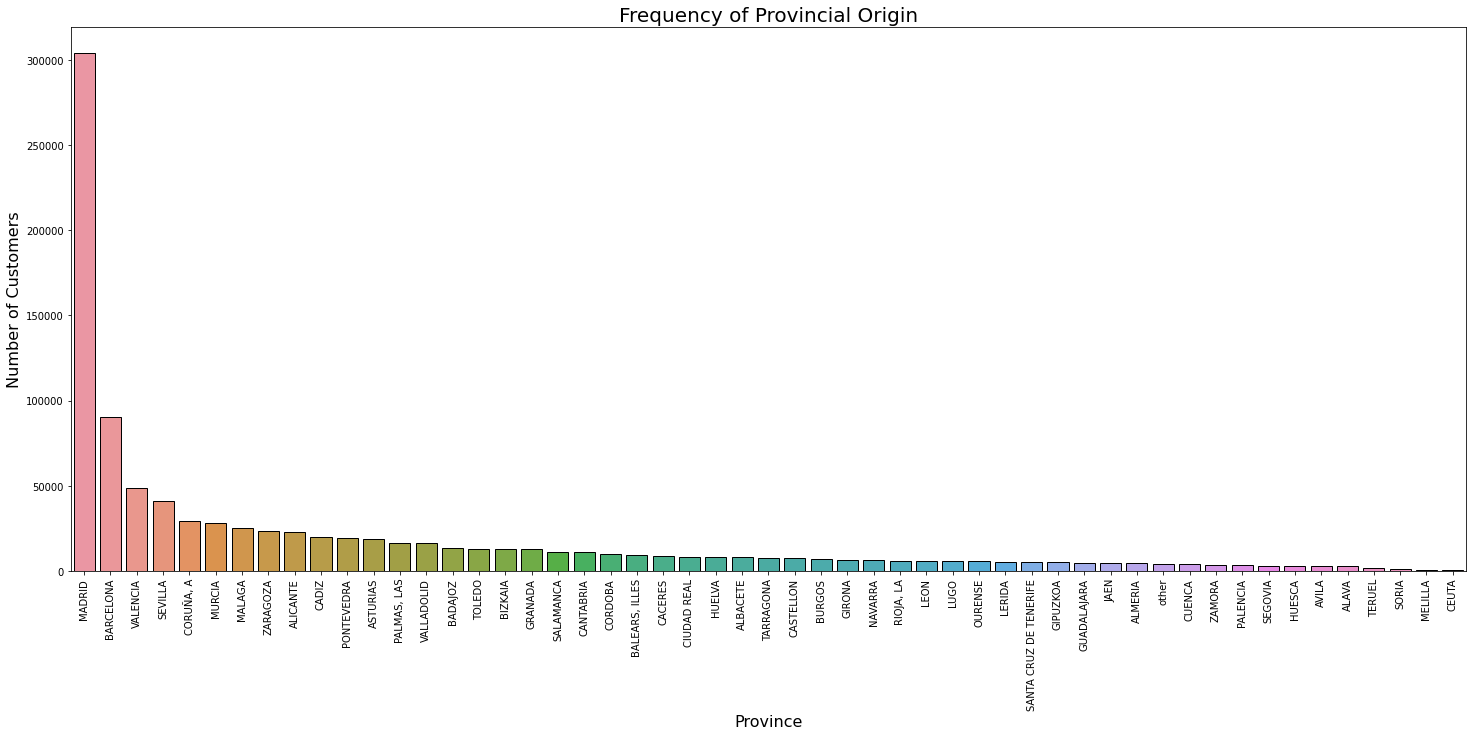

In [ ]:
# Plot Distribution of Provincial Origin
plt.figure(figsize = (25,10))
sns.barplot(x = "province", y = "num_customers", data = province_dist_df);
plt.xticks(rotation = 90);
plt.xlabel('Province', fontsize = 16);
plt.ylabel('Number of Customers', fontsize = 16);
plt.title('Frequency of Provincial Origin', fontsize = 20);

**Observations:** Clearly most customers are from Madrid (the capital) in Spain. As an extension, we now wonder: what is the average income for each province?

Let us investigate this.

In [ ]:
# Get average income per province in SparkSQL
%%spark

query = ''' SELECT province, ROUND(AVG(income),2) as avg_income
            FROM raw_data
            GROUP BY province
            ORDER BY avg_income DESC
            '''

province_income_df = spark.sql(query)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Make available in Colab as Pandas DF
%spark -o province_income_df

# View Top 10
province_income_df.head(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

,province,avg_income
0,CEUTA,199135.91
1,other,188206.20
2,MADRID,178900.52
3,"BALEARS, ILLES",172004.91
4,BARCELONA,164683.26
5,MELILLA,149920.18
6,GIRONA,144306.01
7,GIPUZKOA,142865.87
8,MALAGA,121213.03
9,CANTABRIA,121211.11


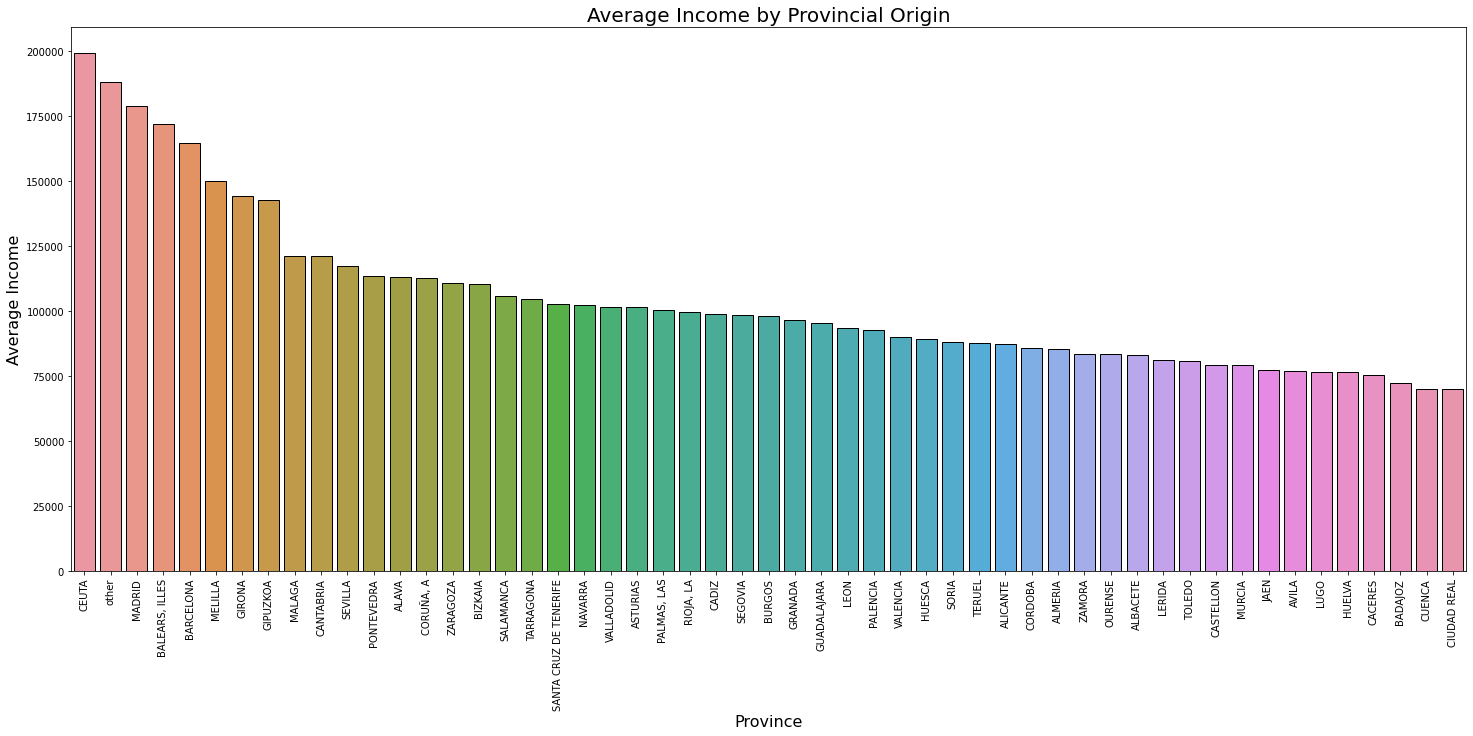

In [ ]:
plt.figure(figsize = (25,10))
sns.barplot(x = "province", y = "avg_income", data = province_income_df);
plt.xticks(rotation = 90);
plt.xlabel('Province', fontsize = 16);
plt.ylabel('Average Income', fontsize = 16);
plt.title('Average Income by Provincial Origin', fontsize = 20);

In [ ]:
# Check out the top 3: 'CEUTA' and 'other' and 'MADRID'
province_merged_df = province_dist_df.merge(province_income_df, how = 'inner', on = 'province')
province_merged_df[(province_merged_df['province'] == 'CEUTA') | (province_merged_df['province'] == 'other') | (province_merged_df['province'] == 'MADRID')]

,province,num_customers,avg_income
0,MADRID,303911,178900.52
41,other,4049,188206.20
52,CEUTA,527,199135.91


**Observations:** While we expected Madrid (the capital) to have the highest average income, it seems this was not the case. Ceuta seems to be the "richest" province in this dataset followed by the "other" province (representing the class where data was missing and we could not impute).

However, if we compare this to the previous chart, we'll notice that this is misleading because the there are substantially fewer people in these than Madrid. This suggests that there may just be a few ultra high net worth individuals in those provinces.

## Section 3: Banking Feature Analysis

This subsection does a deep dive on the Banking Tag and Product feature groups.

#### (a) First Contract Date (Tenure)

This is another one we need to use the subset of the data for.

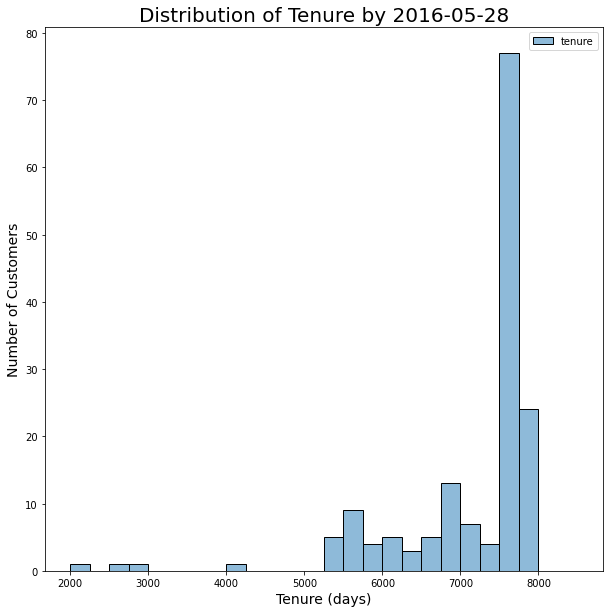

In [ ]:
##### Pandas Version of Plotting #####

### Examine average tenure (time delta will give days)
eda_subset_df['tenure'] = dt.datetime.strptime('2016-05-28', '%Y-%m-%d') - eda_subset_df['first_contract_date']
eda_subset_df['tenure'] = (eda_subset_df['tenure']/np.timedelta64(1, 'D')).astype(int)
tenure_summaries = eda_subset_df[['cust_code', 'tenure']].groupby(by = 'cust_code', axis = 0).mean()

### Distribution of Tenure
plt.figure(figsize = (10,10));
sns.histplot(tenure_summaries,
             binwidth =250,
             binrange = (2000,8251), 
             color = 'green');
plt.rcParams["patch.force_edgecolor"] = True;
plt.xlabel("Tenure (days)", fontsize = 14);
plt.ylabel('Number of Customers', fontsize = 14);
plt.title('Distribution of Tenure by 2016-05-28', fontsize = 20);

**Observations:** Clearly left skewed distribution, where most customers are loyal and have been with the bank for at least 20 years (> 7300 days)!

#### (b) New Customer Boolean

We know most customers are veterans, but let's see how many the bank officially considers "new" vs "old" customers.

In [ ]:
%%spark
query = ''' SELECT new_cust, COUNT(*) as frequency
            FROM raw_data
            GROUP BY new_cust
            '''

spark.sql(query).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+---------+
|new_cust|frequency|
+--------+---------+
|       1|   801059|
|       0| 12793653|
+--------+---------+

**Observations:** No point in creating a visualization here. It's clear that most customers in the dataset are not new, which is in line with the previous chart.

#### (c) Months As Senior Customer

Another one we need to use the subset of the data for. This is the bank's built-in "tenure" feature for those who are not considered new customers who have achieved "Senior" status (though data dictionary does not define what that means).

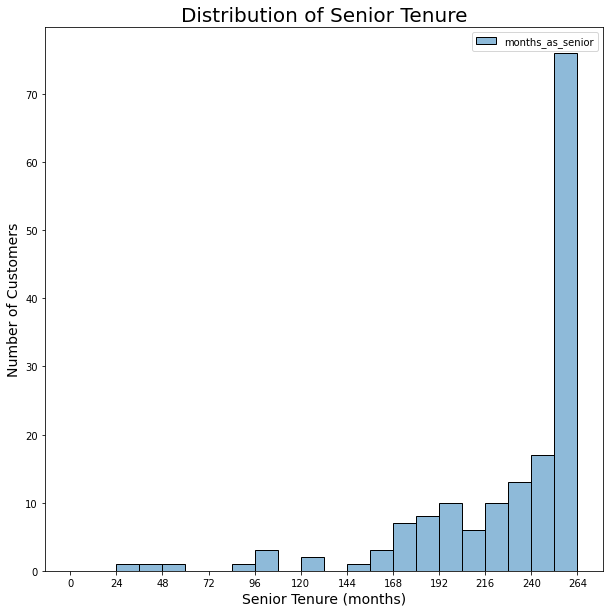

In [ ]:
##### Pandas Version of Plotting #####

### Examine tenure at most recent date
senior_tenure_summaries = eda_subset_df[['cust_code', 'months_as_senior']].groupby(by = 'cust_code', axis = 0).max()

### Plot Distribution of Tenure
plt.figure(figsize = (10,10));
sns.histplot(senior_tenure_summaries, 
             binwidth = 12,
             binrange = (0,264),
             color = 'green');
plt.rcParams["patch.force_edgecolor"] = True;
plt.xlabel("Senior Tenure (months)", fontsize = 14);
plt.xticks(np.arange(0,265,24))
plt.ylabel('Number of Customers', fontsize = 14);
plt.title('Distribution of Senior Tenure', fontsize = 20);

**Observations:** Unsurprisingly the same kind of trend as absolute tenure. Nothing out of the norm here. Again, since this chart was produced from a subset, this should be taken with a grain of salt.

#### (d) Primary Boolean

We did not see a definition for what primary meant in the dataset, so need to investigate.

In [ ]:
%%spark
query = ''' SELECT primary, COUNT(*) as frequency
            FROM raw_data
            GROUP BY primary
            '''

spark.sql(query).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------+
|primary|frequency|
+-------+---------+
|      1| 13594712|
+-------+---------+

**Observation:** Everybody is primary, so no varation in this column. We certainly won't need to use this as a feature.

#### (e) Last Date as Primary Customer

We expect this to be all NULL because all customers are still Primary.

In [ ]:
%%spark
query = ''' SELECT last_date_as_primary, COUNT(*) as frequency
            FROM raw_data
            GROUP BY last_date_as_primary
            '''

spark.sql(query).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---------+
|last_date_as_primary|frequency|
+--------------------+---------+
|                null| 13594712|
+--------------------+---------+

**Observation:** Consistent with `primary` count, so no bad data here. Another redundant column that we don't need to plot.

#### (f) Customer Type

Check the distribution of Customer Type. As a reminder, the data dictionary says:
- 1: First/Primary customer
- 2: Co-owner
- P: Potential
- 3: Former primary
- 4: Former co-owner

In [ ]:
# SparkSQl query to get customer type
%%spark
query = ''' SELECT cust_type, COUNT(*) as frequency
            FROM raw_data
            GROUP BY cust_type
            ORDER BY cust_type
            '''

cust_type_df = spark.sql(query)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Make available in Colab 
%spark -o cust_type_df

# View
cust_type_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

,cust_type,frequency
0,1,13470306
1,2,1301
2,3,3833
3,4,292
4,P,845
5,other,118135


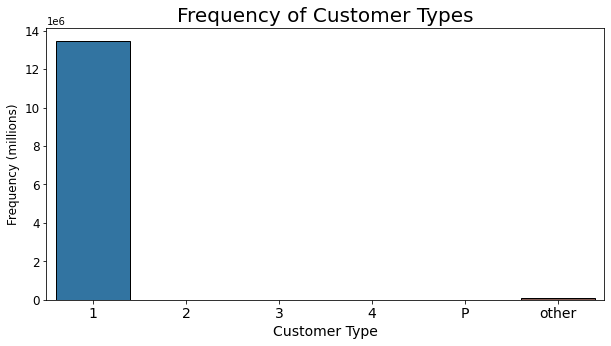

In [ ]:
# Plot customer type frequencies (raw counts in case customer changed type)
plt.figure(figsize = (10,5))
sns.barplot(x = 'cust_type', y = 'frequency', data = cust_type_df);
plt.xlabel('Customer Type', fontsize = 14);
plt.xticks(fontsize = 14)
plt.ticklabel_format(axis="y", style="sci", scilimits=(6,6));
plt.ylabel('Frequency (millions)', fontsize = 12);
plt.yticks(fontsize = 12)
plt.title('Frequency of Customer Types', fontsize = 20);

**Observations:**
- From the raw counts seen in that table, we see that this is a bit inconsistent since "primary" here does not seem to mean the same thing as the `primary` feature. There is no further explanation in the data dictionary. 
- However, most customers still end up being "primary"

#### (g) Active Boolean

Check the distribution of active customers.

In [ ]:
# SparkSQL query for active
%%spark
query = ''' SELECT active, COUNT(*) as frequency
            FROM raw_data
            GROUP BY active
            '''

active_df = spark.sql(query)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Make available in Colab 
%spark -o active_df

# View
active_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

,active,frequency
0,1,6233329
1,0,7361383


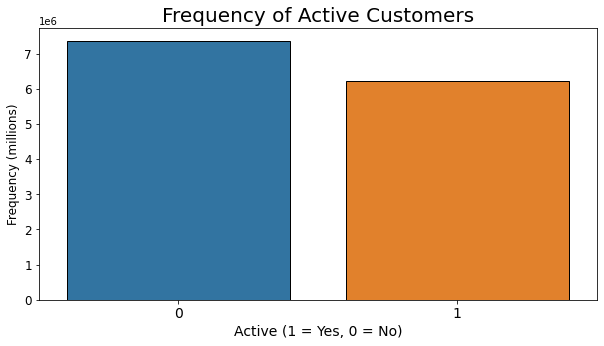

In [ ]:
# Plot active_df frequencies (raw counts in case customer changed active class)
plt.figure(figsize = (10,5))
sns.barplot(x = 'active', y = 'frequency', data = active_df);
plt.xlabel('Active (1 = Yes, 0 = No)', fontsize = 14);
plt.xticks(fontsize = 14)
plt.ticklabel_format(axis="y", style="sci", scilimits=(6,6));
plt.ylabel('Frequency (millions)', fontsize = 12);
plt.yticks(fontsize = 12)
plt.title('Frequency of Active Customers', fontsize = 20);

**Observations:** Surprisingly most customers are not "active". The data dictionary doesn't explain what "active" really mean though. We can probably assume this means frequent user of bank services via visits or withdrawls, though that data is not provided.

#### (h) Relationship Type

Check the distribution of relationship type. As a reminder, the data dictionary defines this as "relation type at the beginning of the month":
- A: active
- I: inactive
- P: former customer
- R: Potential

In [ ]:
# SparkSQL query to get relationship type
%%spark
query = ''' SELECT rel_type, COUNT(*) as frequency
            FROM raw_data
            GROUP BY rel_type
            ORDER BY rel_type
            '''

rel_type_df = spark.sql(query)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Make available in Colab 
%spark -o rel_type_df

# View
rel_type_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

,rel_type,frequency
0,A,6176123
1,I,7295484
2,N,4
3,P,4125
4,R,841
5,other,118135


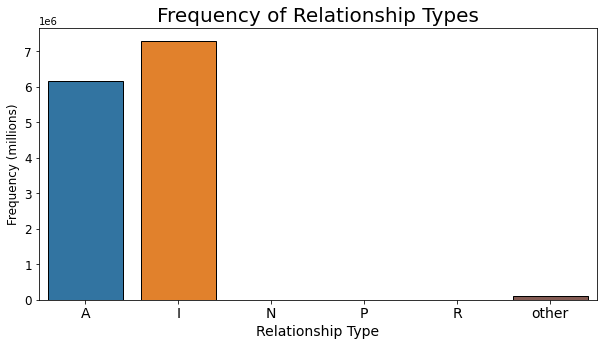

In [ ]:
# Plot relationship type frequencies (raw counts in case customer changed type)
plt.figure(figsize = (10,5))
sns.barplot(x = 'rel_type', y = 'frequency', data = rel_type_df);
plt.xlabel('Relationship Type', fontsize = 14);
plt.xticks(fontsize = 14)
plt.ticklabel_format(axis="y", style="sci", scilimits=(6,6));
plt.ylabel('Frequency (millions)', fontsize = 12);
plt.yticks(fontsize = 12)
plt.title('Frequency of Relationship Types', fontsize = 20);

**Observations:** 
- Like the link between `customer_type` and `primary`, this features seems to link (though somewhat inconsistently) with the `active` boolean feature in Section (g) preceeding this.
- Nonetheless, the general order of magnitude seems to agree. This just appears to be more granular.

#### (i) Different Birth Country Boolean

Check how many customers are actually Spanish citizens.

In [ ]:
# Spark SQL
%%spark
query = ''' SELECT diff_birth_country, COUNT(DISTINCT cust_code) as num_customers
            FROM raw_data
            GROUP BY diff_birth_country
            ORDER BY num_customers DESC
            '''

birth_df = spark.sql(query)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Make available in Colab 
%spark -o birth_df

# View first few rows
birth_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

,diff_birth_country,num_customers
0,N,896969
1,S,47259


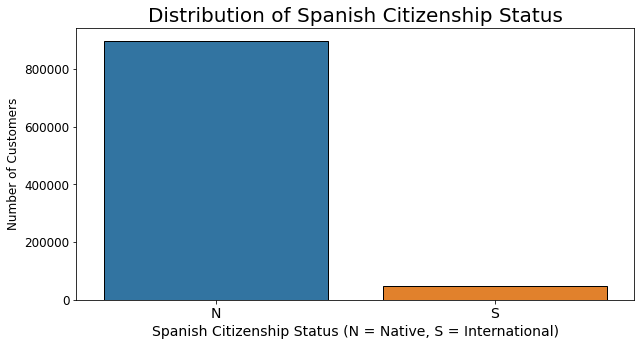

In [ ]:
# Plot distribution of spanish citizen boolean
plt.figure(figsize = (10,5))
sns.barplot(x = 'diff_birth_country', y = 'num_customers', data = birth_df);
plt.xlabel('Spanish Citizenship Status (N = Native, S = International)', fontsize = 14);
plt.xticks(fontsize = 14)
# plt.ticklabel_format(axis="y", style="sci", scilimits=(6,6));
plt.ylabel('Number of Customers', fontsize = 12);
plt.yticks(fontsize = 12)
plt.title('Distribution of Spanish Citizenship Status', fontsize = 20);

**Observations:** Unsurpisingly most users of a Spanish Bank in Spain are Spanish!

#### (j) Employee Spouse Boolean

Check the distribution of how many customers are spouses of employees.

In [ ]:
%%spark
query = ''' SELECT emp_spouse, COUNT(*) as frequency
            FROM raw_data
            GROUP BY emp_spouse
            '''

spark.sql(query).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+---------+
|emp_spouse|frequency|
+----------+---------+
|         S|       17|
|         N| 13594695|
+----------+---------+

**Observations:** No need to a plot here to see that most customers are not spouses of employees. Only 17 out of the 13 million or so are. This is unlikely to be a distinguishing feature.

#### (k) Joining Channel

Check the distribution of Joining Channels (though we aren't told what these are in the Data Dictionary).

In [ ]:
%%spark

query = ''' SELECT joining_channel, COUNT(DISTINCT cust_code) as num_customers
            FROM raw_data
            GROUP BY joining_channel
            ORDER BY num_customers DESC
            '''

channel_dist_df = spark.sql(query)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Make available in Colab as Pandas DF
%spark -o channel_dist_df

# View Top 10
channel_dist_df.head(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

,joining_channel,num_customers
0,KHE,254130
1,KAT,208605
2,KFC,203382
3,other,132588
4,KHQ,75997
5,KHM,33456
6,KFA,26242
7,KHN,18406
8,KHK,17909
9,KHD,7480


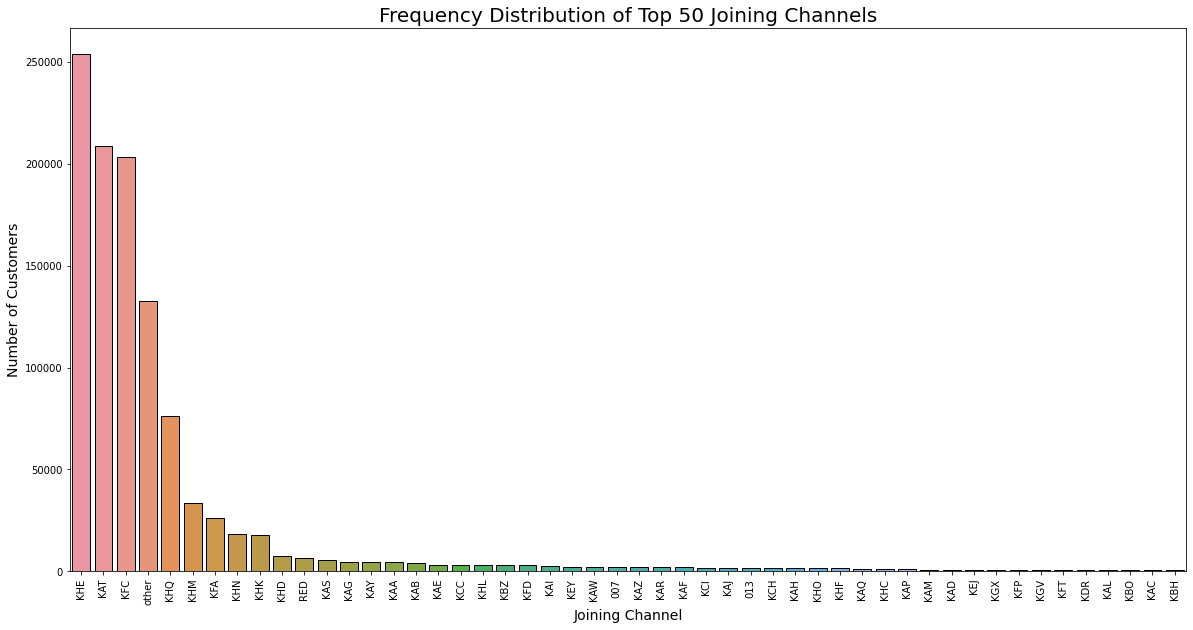

In [ ]:
# There are too many channels to plot on one barchart so just getting the top 50 to show
plt.figure(figsize = (20,10))
sns.barplot(x = "joining_channel", y = "num_customers", data = channel_dist_df.head(50));
plt.xticks(rotation = 90);
plt.xlabel('Joining Channel', fontsize = 14);
plt.ylabel('Number of Customers', fontsize = 14);
plt.title('Frequency Distribution of Top 50 Joining Channels', fontsize = 20);

**Observations:** It is difficult to give an interpreation for this since we have no context whatsoever for what these Joining Channels actually represent. They are highly numerous though only the top 3 most dense channels are KHE, KAT, and KFC.

### (l) Banking Diversification: Total Banking Product Accounts ever Opened by Customers

To get a sense of whether customers are diversifying their financial assets and also as a way to gauge overall demand for Santander banking products, we can look at the total number of accounts ever opened for each customer and tally up those counts. Since we are gauging overall demand throughout the customer lifetime, we use max here to ignore cases when a customer has closed an a particular account.

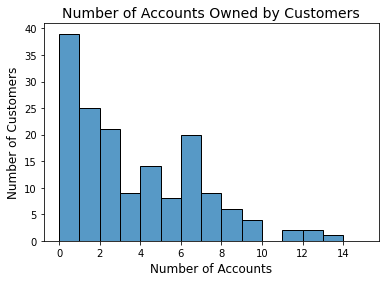

In [ ]:
### Get total number of accounts per product

# Group By Customer ID then check accounts ever opened for each customer
account_summaries = eda_subset_df[['cust_code'] + product_dummies].groupby(by = 'cust_code', axis = 0).max()

# Extract to Pandas Series
total_product_engagements = account_summaries.sum(axis = 1)

# Plot
sns.histplot(total_product_engagements,
             binwidth = 1,
             binrange = (0,15))
plt.xlabel('Number of Accounts', fontsize = 12);
plt.ylabel('Number of Customers', fontsize = 12);
plt.title('Number of Accounts Owned by Customers', fontsize = 14);

**Observations:** At least in the random subset, most customers appear to have only 1 account throughout the course of their life. This seems to steadily decrease as expected. The highest number of accounts in this subset is 14 (of the 24) banking product accounts.

This concludes our deep dive into every one of the features. Next up, we'll be using these insights to construct features in the Feature Engineering and Unsupervised Learning notebook.